# Survey Property maps

Notebook to:
- Convert DECASU Survey Property maps to a suitable format to apply deprojection within the TXPipe pipeline
- Save at different resolutions, nside = 512 and 2048
- Organize

## Conversion
Script to convert from Healsparse to Healpix the observing conditions maps and also to degrade the resolution, from $n_{side} = 16384$ to $2048$ in order to be ingested in TXPipe and create the final data vector considering deprojection.

In [1]:
import healpy as hp
import sys
sys.path.insert(0, '/global/homes/d/davidsan/healsparse')
import healsparse as hsp
import os
from astropy.io import fits
import numpy as np

In [2]:
path_to_read = '/global/cfs/projectdirs/lsst/groups/LSS/HSC_data/decasu_maps'

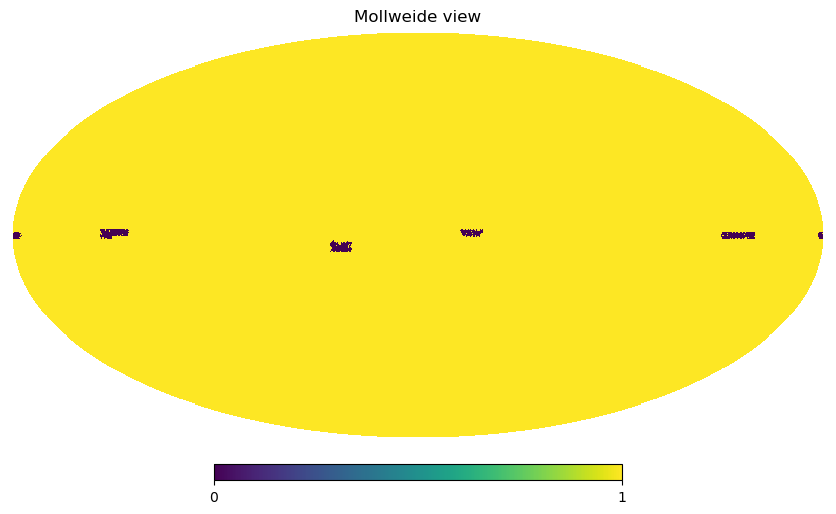

In [3]:
# Apply mask
fname_mask = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/mask/masked_fraction_nside4096_gama09hcorr_nohectomap.hs'
mask = hsp.HealSparseMap.read(fname_mask).generate_healpix_map(nside=2048, nest=False)
mask = np.where(mask != hp.UNSEEN, 0, 1)
hp.mollview(mask)

In [5]:
apply_mask = False

for nside in np.array([512, 2048]):
    print(f'>> Working with SP maps at nside = {nside}')
    # Apply mask
    fname_mask = '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/mask/masked_fraction_nside4096_gama09hcorr_nohectomap.hs'
    if apply_mask == True:
        print('>> Applying mask')
        mask = hsp.HealSparseMap.read(fname).generate_healpix_map(nside=2048, nest=False)
        mask = np.where(mask != hp.UNSEEN, 0, 1)
    path_to_save = f'/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_{nside}'
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
        print(f"Path '{path_to_save}' created successfully.")
    else:
        print(f"Path '{path_to_save}' already exists.")
    for file in os.listdir(path_to_read):
        if file.startswith("s16a"):
            print('Reading map and converting: ', file)
            fname = os.path.join(path_to_read, file)
            hsp_map = hsp.HealSparseMap.read(fname).generate_healpix_map(nside=nside, nest=False)
            # Apply mask
            if apply_mask == True:
                hsp_map[mask] = hp.UNSEEN
            print("Saving as healpix map...")
            hdu = fits.PrimaryHDU(hsp_map)
            hdu.writeto(os.path.join(path_to_save, file[:-2]+'fits'), overwrite=True)

>> Working with SP maps at nside = 512
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512' already exists.
Reading map and converting:  s16a_wide_v3_g_maglim_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_i_airmass_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_g_exptime_sum.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_g_dcr_e1_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_dcr_e1_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_y_dcr_ddec_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_nexp_sum.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_airmass_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_i_dcr_dra_wmean.hs
Saving as healpix map...
Reading map and converting:  s16a_wide_v3_r_dcr_ddec_wmean.hs
Saving as healpix map...

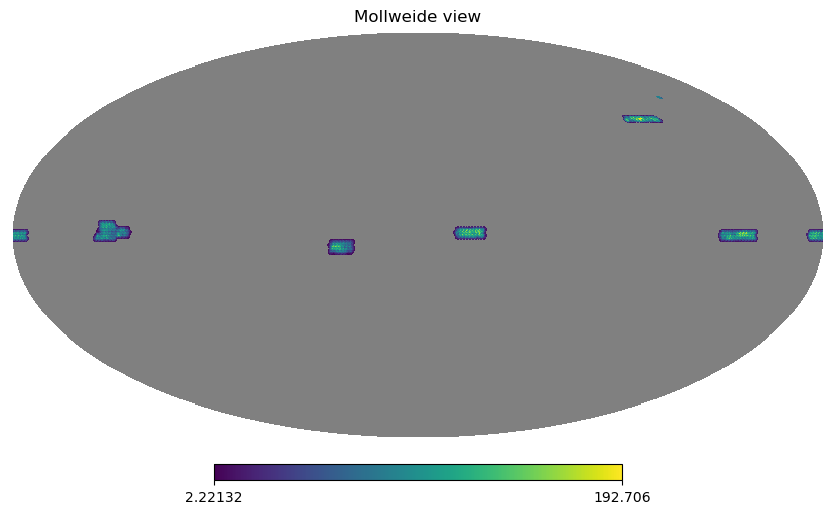

In [6]:
hp.mollview(hsp_map)

### CMB maps

Thermal Sunyaev-Zeldovich map

In [7]:
path = "/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/"
path_syst = os.path.join(path, 'systematics_maps/maps_2048')
path_syst_save_512 = os.path.join(path, 'systematics_maps/cmb_maps_512')
path_syst_save_2048 = os.path.join(path, 'systematics_maps/cmb_maps_2048')

In [8]:
# Generate mask, where to consider CMB info
fname_syst = os.listdir(path_syst)[0]
syst_map = fits.open(os.path.join(path_syst, fname_syst))[0].data
mask = np.where(syst_map != hp.UNSEEN)[0]

#### thermal Sunyaev-Zeldovich

In [9]:
from astropy.table import Table

In [10]:
fname_tsz = os.path.join('/pscratch/sd/d/davidsan/3x2pt-HSC/thermalSZ/COM_CompMap_Compton-SZMap-nilc-ymaps_2048_R2.00.fits')
table = Table.read(fname_tsz)
full_ymap_2048 = np.array(table['FULL'])

# nside = 2048
full_ymap_2048_mask = np.ones(12*2048**2) * hp.UNSEEN
full_ymap_2048_mask[mask] = full_ymap_2048[mask]
hp.write_map(os.path.join(path_syst_save_2048, 'tSZ_nside_2048.fits'), full_ymap_2048_mask, nest=False, overwrite=True)

# Degrading to nside = 512
full_ymap_512_mask = hp.pixelfunc.ud_grade(map_in = full_ymap_2048_mask, nside_out = 512)
hp.write_map(os.path.join(path_syst_save_512, 'tSZ_nside_512.fits'), full_ymap_512_mask, nest=False, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


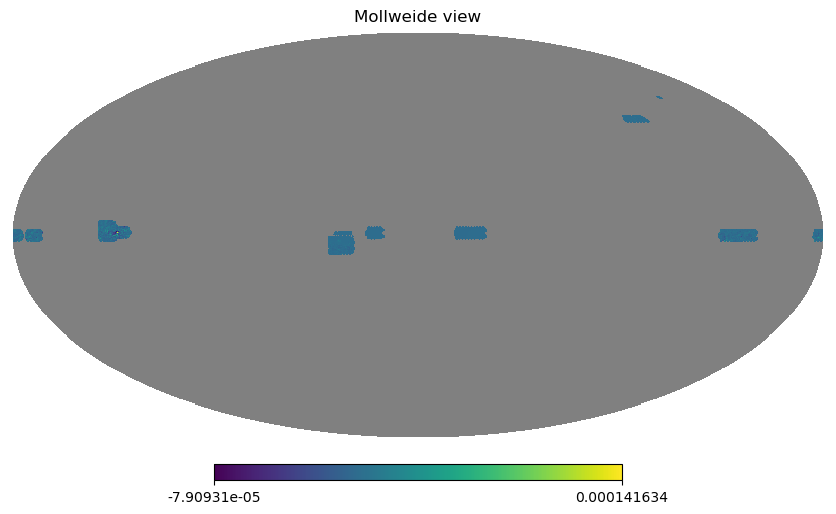

In [11]:
hp.mollview(full_ymap_2048_mask)

#### CMB Lensing (CMB $\kappa$)

In [12]:
fname_kappa = os.path.join('/pscratch/sd/d/davidsan/3x2pt-HSC/CMBKappa/COM_CompMap_Lensing_2048_R1.10.fits')
table = Table.read(fname_kappa, hdu=1)
# CMB Lensing map
kappa = table['PHIBAR']
# Converting from NEST to RING ordering
kappa = hp.pixelfunc.reorder(map_in=kappa, n2r=True)

kappa_2048 = np.ones(12*2048**2) * hp.UNSEEN
kappa_2048[mask] = kappa[mask]
hp.write_map(os.path.join(path_syst_save_2048, 'CMB_kappa_nside_2048.fits'), kappa_2048, nest=False, overwrite=True)

kappa_512 = hp.pixelfunc.ud_grade(map_in = kappa_2048, nside_out = 512)
hp.write_map(os.path.join(path_syst_save_512, 'CMB_kappa_nside_512.fits'), kappa_512, nest=False, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


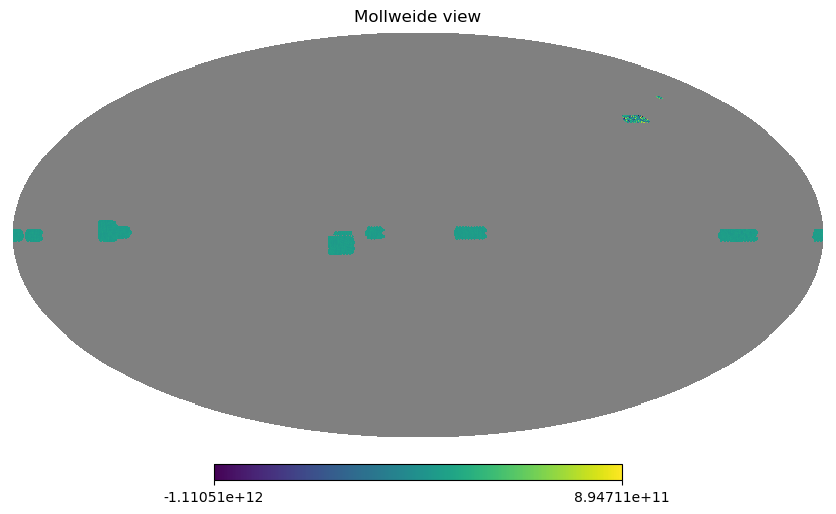

In [13]:
hp.mollview(kappa_2048)

## Normalize SP maps

In [1]:
from tqdm import tqdm
import h5py
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Normalizing SP maps at nside = 512
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/normalized' already exists.
/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors


  0%|          | 0/11 [00:00<?, ?it/s]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_y_dcr_e1_wmean.fits
Reading  s16a_wide_v3_y_dcr_e1_wmean.fits
Masking table...


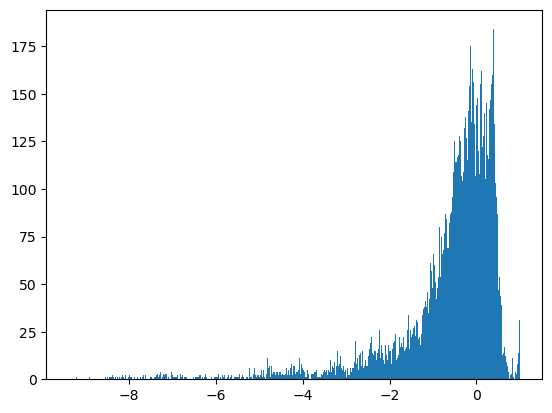

setting the output map dtype to [dtype('>f8')]
  9%|▉         | 1/11 [00:01<00:16,  1.68s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_i_dcr_e1_wmean.fits
Reading  s16a_wide_v3_i_dcr_e1_wmean.fits
Masking table...


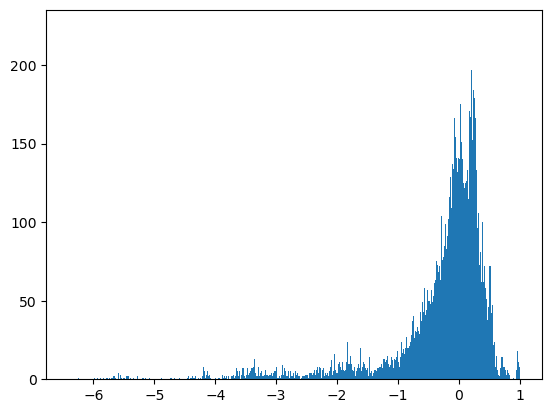

setting the output map dtype to [dtype('>f8')]
 18%|█▊        | 2/11 [00:03<00:14,  1.65s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_r_dcr_e2_wmean.fits
Reading  s16a_wide_v3_r_dcr_e2_wmean.fits
Masking table...


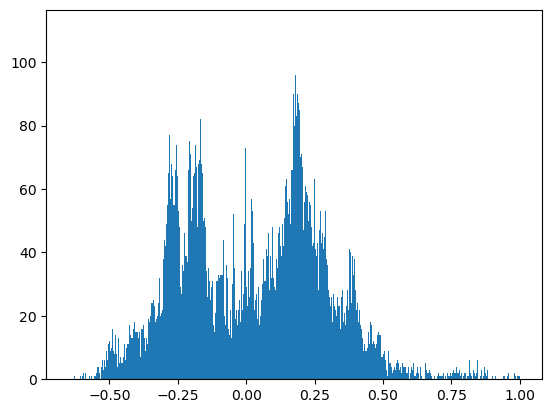

setting the output map dtype to [dtype('>f8')]
 27%|██▋       | 3/11 [00:05<00:13,  1.69s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_g_dcr_e1_wmean.fits
Reading  s16a_wide_v3_g_dcr_e1_wmean.fits
Masking table...


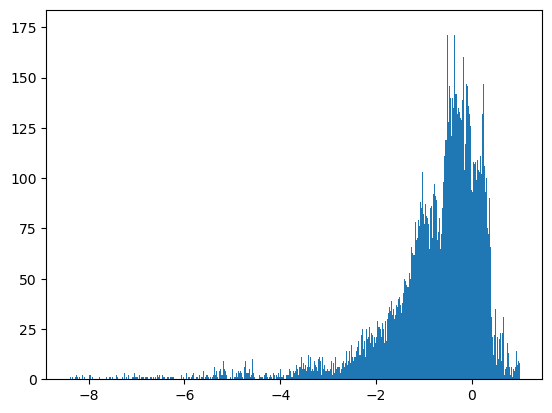

setting the output map dtype to [dtype('>f8')]
 45%|████▌     | 5/11 [00:06<00:07,  1.20s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_z_dcr_e2_wmean.fits
Reading  s16a_wide_v3_z_dcr_e2_wmean.fits
Masking table...


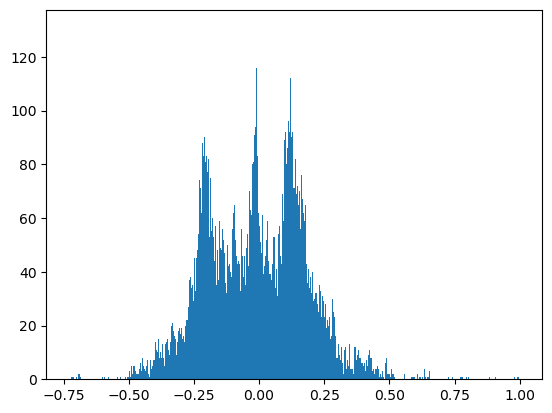

setting the output map dtype to [dtype('>f8')]
 55%|█████▍    | 6/11 [00:08<00:06,  1.31s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_i_dcr_e2_wmean.fits
Reading  s16a_wide_v3_i_dcr_e2_wmean.fits
Masking table...


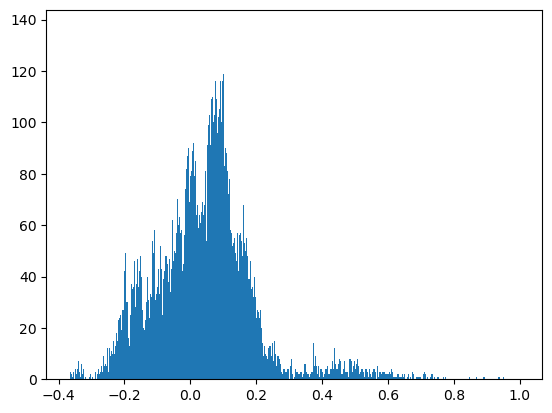

setting the output map dtype to [dtype('>f8')]
 64%|██████▎   | 7/11 [00:09<00:05,  1.41s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_r_dcr_e1_wmean.fits
Reading  s16a_wide_v3_r_dcr_e1_wmean.fits
Masking table...


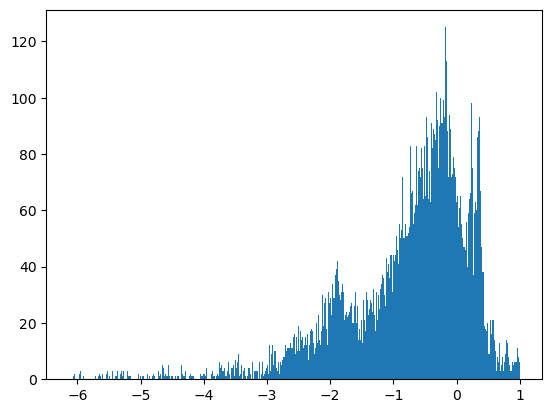

setting the output map dtype to [dtype('>f8')]
 73%|███████▎  | 8/11 [00:11<00:04,  1.49s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_y_dcr_e2_wmean.fits
Reading  s16a_wide_v3_y_dcr_e2_wmean.fits
Masking table...


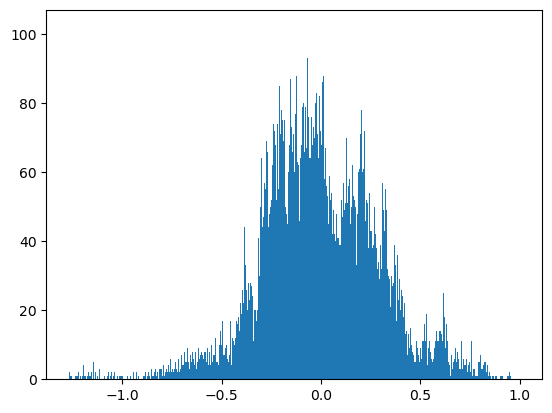

setting the output map dtype to [dtype('>f8')]
 82%|████████▏ | 9/11 [00:13<00:03,  1.52s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_z_dcr_e1_wmean.fits
Reading  s16a_wide_v3_z_dcr_e1_wmean.fits
Masking table...


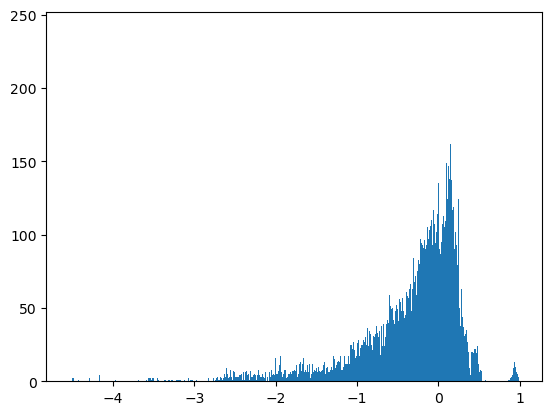

setting the output map dtype to [dtype('>f8')]
 91%|█████████ | 10/11 [00:14<00:01,  1.54s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_512/tensors/s16a_wide_v3_g_dcr_e2_wmean.fits
Reading  s16a_wide_v3_g_dcr_e2_wmean.fits
Masking table...


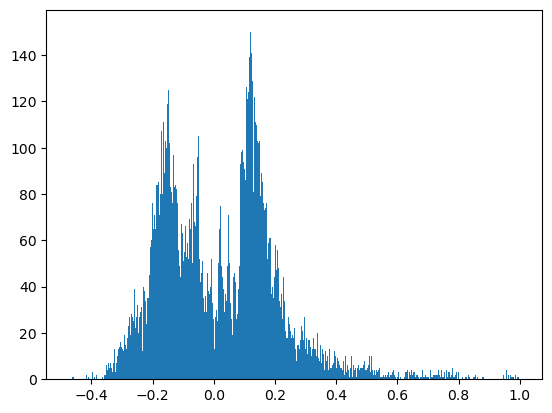

setting the output map dtype to [dtype('>f8')]
100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


Normalizing SP maps at nside = 2048
Path '/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/normalized' already exists.
/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors


  0%|          | 0/12 [00:00<?, ?it/s]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_y_dcr_e1_wmean.fits
Reading  s16a_wide_v3_y_dcr_e1_wmean.fits
Masking table...


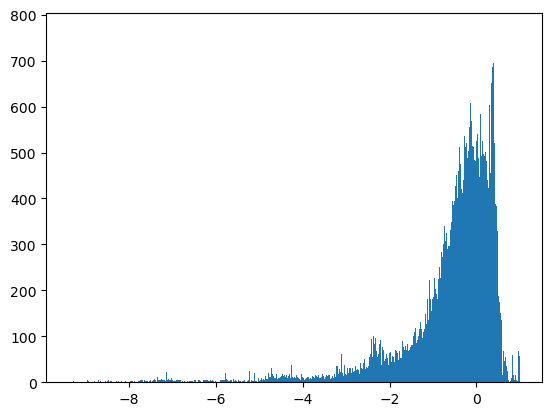

setting the output map dtype to [dtype('>f8')]
  8%|▊         | 1/12 [00:08<01:30,  8.21s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_i_dcr_e1_wmean.fits
Reading  s16a_wide_v3_i_dcr_e1_wmean.fits
Masking table...


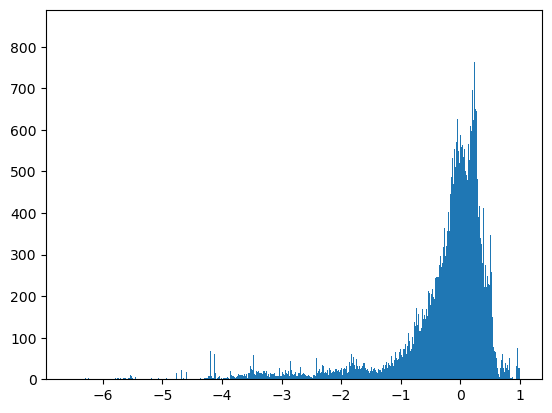

setting the output map dtype to [dtype('>f8')]
 17%|█▋        | 2/12 [00:15<01:19,  7.95s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_r_dcr_e2_wmean.fits
Reading  s16a_wide_v3_r_dcr_e2_wmean.fits
Masking table...


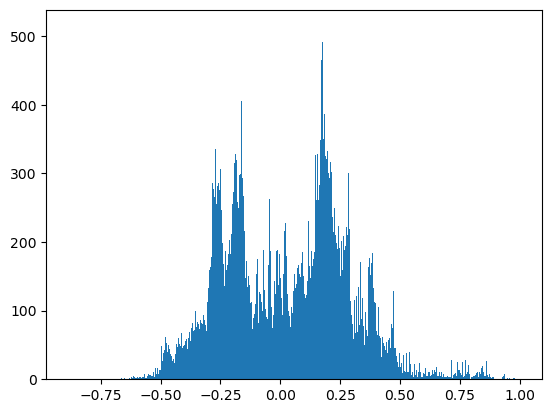

setting the output map dtype to [dtype('>f8')]
 25%|██▌       | 3/12 [00:23<01:09,  7.78s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_g_dcr_e1_wmean.fits
Reading  s16a_wide_v3_g_dcr_e1_wmean.fits
Masking table...


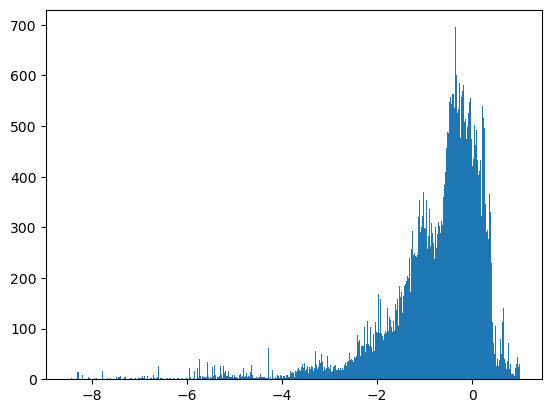

setting the output map dtype to [dtype('>f8')]
 42%|████▏     | 5/12 [00:31<00:39,  5.71s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_z_dcr_e2_wmean.fits
Reading  s16a_wide_v3_z_dcr_e2_wmean.fits
Masking table...


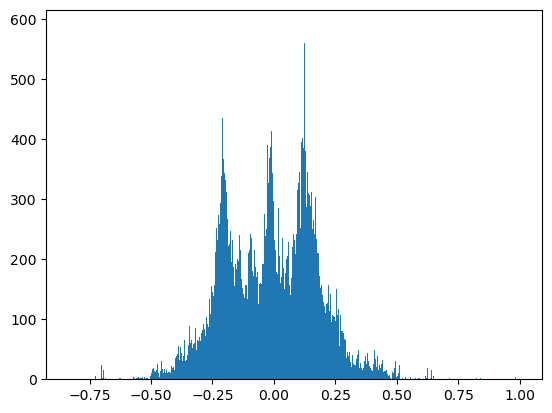

setting the output map dtype to [dtype('>f8')]
 50%|█████     | 6/12 [00:39<00:37,  6.32s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_i_dcr_e2_wmean.fits
Reading  s16a_wide_v3_i_dcr_e2_wmean.fits
Masking table...


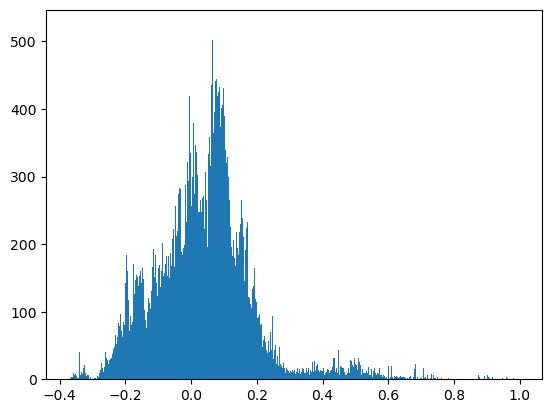

setting the output map dtype to [dtype('>f8')]
 67%|██████▋   | 8/12 [00:47<00:21,  5.35s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_r_dcr_e1_wmean.fits
Reading  s16a_wide_v3_r_dcr_e1_wmean.fits
Masking table...


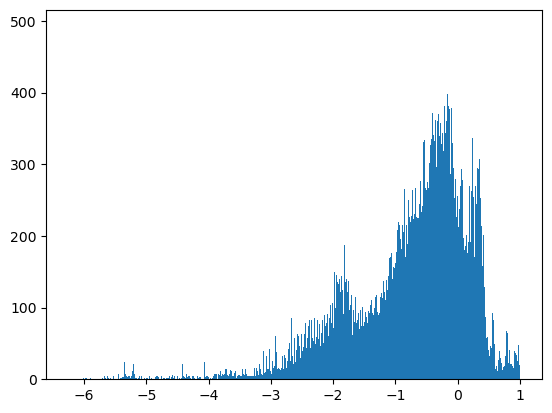

setting the output map dtype to [dtype('>f8')]
 75%|███████▌  | 9/12 [00:56<00:18,  6.16s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_y_dcr_e2_wmean.fits
Reading  s16a_wide_v3_y_dcr_e2_wmean.fits
Masking table...


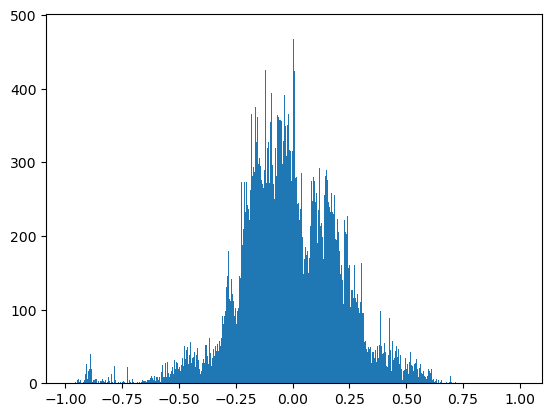

setting the output map dtype to [dtype('>f8')]
 83%|████████▎ | 10/12 [01:04<00:13,  6.58s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_z_dcr_e1_wmean.fits
Reading  s16a_wide_v3_z_dcr_e1_wmean.fits
Masking table...


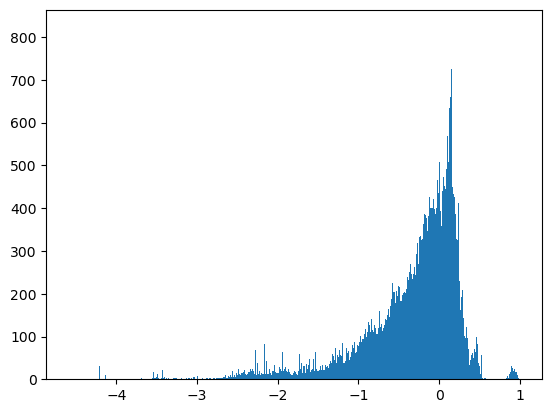

setting the output map dtype to [dtype('>f8')]
 92%|█████████▏| 11/12 [01:12<00:06,  6.91s/it]

/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/systematics_maps/maps_2048/tensors/s16a_wide_v3_g_dcr_e2_wmean.fits
Reading  s16a_wide_v3_g_dcr_e2_wmean.fits
Masking table...


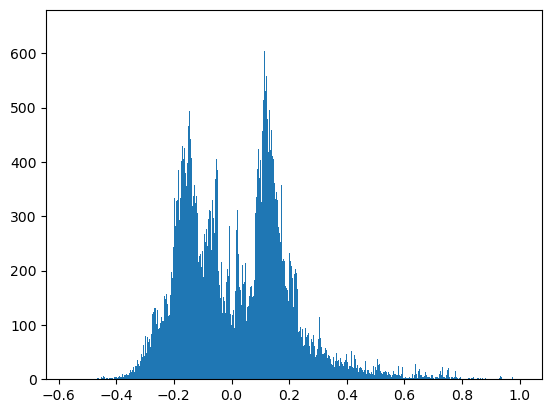

setting the output map dtype to [dtype('>f8')]
100%|██████████| 12/12 [01:20<00:00,  6.68s/it]


In [2]:
### Tensor maps
path_proj = "/pscratch/sd/d/davidsan/HSC-PDR1-3x2pt-harmonic-methods/data/"

for nside in np.array([512,2048]):
    print(f'Normalizing SP maps at nside = {nside}')
    # Just applying PCA to scalar maps
    if nside == 512:
        path_sys_maps = os.path.join(path_proj, "systematics_maps/maps_512/tensors")
    elif nside == 2048:
        path_sys_maps = os.path.join(path_proj, "systematics_maps/maps_2048/tensors")
    path_to_save = os.path.join(path_sys_maps, "normalized")
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
        print(f"Path '{path_to_save}' created successfully.")
    else:
        print(f"Path '{path_to_save}' already exists.")
    print(path_sys_maps)
    for map_name in tqdm(os.listdir(path_sys_maps)):
        if "s16a" in map_name:
            fname_sys = os.path.join(path_sys_maps, map_name)
            print(fname_sys)
            print('Reading ', map_name)
            with fits.open(fname_sys) as data:
                print('Masking table...')
                map_ = data[0].data

            # plt.hist(map_[map_ != hp.UNSEEN],bins=int(np.sqrt(len(map_))))
            # plt.show()

            # Normalization
            map_[map_ != hp.UNSEEN] /= max(map_[map_ != hp.UNSEEN])

            plt.hist(map_[map_ != hp.UNSEEN],bins=int(np.sqrt(len(map_))))
            plt.show()

            # Saving normalized maps
            hp.write_map(os.path.join(path_to_save, 'norm_'+map_name), map_, nest=False, overwrite=True)